### Features:
#### 1. Bag of Words (BOW) counts (10000 words with maximum frequency)
#### 2. Number of characters in an essay
#### 3. Number of words in an essay
#### 4. Number of sentences in an essay
#### 5. Average word length of an essay
#### 6. Number of lemmas in an essay
#### 7. Number of spellng errors in an essay
#### 8. Number of nouns in an essay
#### 9. Number of adjectives in an essay
#### 10. Number of verbs in an essay
#### 11. Number of adverbs in an essay

### Models:

#### 1. Using only BOW features:
####     a. Linear Regression
####     b. Lasso Regression
#### 2. Using only numerical/POS/Orthographic features:
####     a. Linear Regression
####     b. Ridge Regression
####     c. Lasso Regression
####     d. Gradient Boosting Regression
#### 3. Using all features:
####     a. Linear Regression
####     b. Ridge Regression
####     c. Lasso Regression
####     d. Support Vector Regression
####     e. Gradient Boosting Regression

## Model Evaluation:

### 1. Parameter Tuning: Using GridSearchCV
### 2. Error: mean_squared_error - a risk metric corresponding to the expected value of the squared (quadratic) error or loss
### 3. Variance: estimator score() function or r2_score - R², the coefficient of determination; provides a measure of how well future samples are likely to be predicted by the model
### 4. Score Agreement: cohen_kappa_score - measures inter-rater agreement; takes into account the possibility of the agreement occurring by chance

In [1]:
# importing required packages

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

In [2]:
# getting data in a pandas dataframe

dataframe = pd.read_csv('essays_and_scores.csv', encoding = 'latin-1')

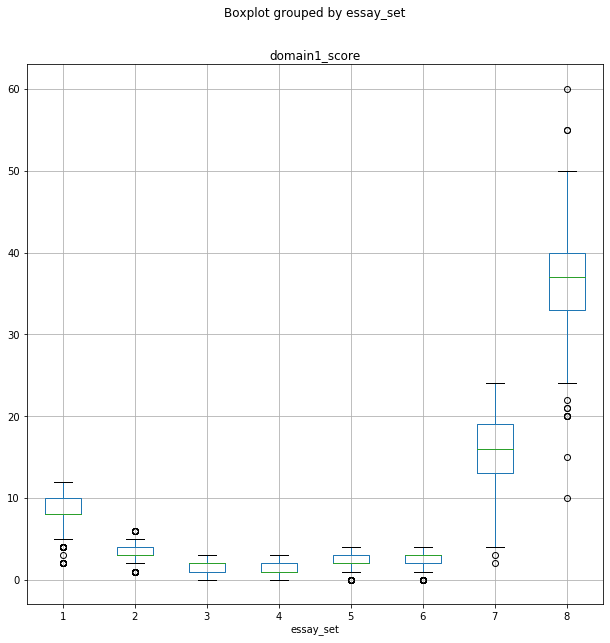

In [3]:
# Boxlot can be used to visualize the distribution of domain1_score values over each essay set.

%matplotlib inline
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [4]:
# getting relevant columns

data = dataframe[['essay_set','essay','domain1_score']].copy()

data

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,1,"Dear @LOCATION1, I know having computers has a...",8.0
...,...,...,...
12973,8,In most stories mothers and daughters are eit...,35.0
12974,8,I never understood the meaning laughter is th...,32.0
12975,8,"When you laugh, is @CAPS5 out of habit, or is ...",40.0
12976,8,Trippin' on fen...,40.0


In [5]:
# Tokenize a sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [6]:
# tokenizing an essay into a list of word lists

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [7]:
# calculating average word length in an essay

def avg_word_len(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return sum(len(word) for word in words) / len(words)

In [8]:
# calculating number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [9]:
# calculating number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [10]:
# calculating number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [11]:
# calculating number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [12]:
# checking number of misspelled words

def count_spell_error(essay):
    
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
    
    #big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg 
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()
    
    words_ = re.findall('[a-z]+', data.lower())
    
    word_dict = collections.defaultdict(lambda: 0)
                       
    for word in words_:
        word_dict[word] += 1
                       
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
                        
    mispell_count = 0
    
    words = clean_essay.split()
                        
    for word in words:
        if not word in word_dict:
            mispell_count += 1
    
    return mispell_count

In [13]:
# calculating number of nouns, adjectives, verbs and adverbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count
    

In [14]:
# getiing Bag of Words (BOW) counts

def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [20]:
# splitting data into train data and test data (70/30)

feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 1]['essay'])

X_cv = count_vectors.toarray()

y_cv = data[data['essay_set'] == 1]['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [22]:
obj = [X_cv, y_cv]
pickle.dump(obj, open('obj.sav','wb'))

In [15]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['spell_err_count'] = features['essay'].apply(count_spell_error)
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [16]:
# extracting features from essay set 1

features_set1 = extract_features(data[data['essay_set'] == 1])

print(features_set1)

      essay_set                                              essay  \
0             1  Dear local newspaper, I think effects computer...   
1             1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             1  Dear Local Newspaper, @CAPS1 I have found that...   
4             1  Dear @LOCATION1, I know having computers has a...   
...         ...                                                ...   
1778          1  Dear @CAPS1, @CAPS2 several reasons on way I t...   
1779          1  Do a adults and kids spend to much time on the...   
1780          1  My opinion is that people should have computer...   
1781          1  Dear readers, I think that its good and bad to...   
1782          1  Dear - Local Newspaper I agree thats computers...   

      domain1_score  char_count  word_count  sent_count  avg_word_len  \
0               8.0        1538         350          16      4.237143   
1            

In [17]:
import pickle

In [18]:
pickle.dump(features_set1, open('preprocessed.sav','wb'))